In [6]:
!pip install simpy


In [7]:
import simpy
import random
import numpy as np

def queue_simulation(arrival_rate, service_rate, num_servers, sim_time=1000):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=num_servers)

    waiting_times = []

    def customer(env):
        arrival_time = env.now

        with server.request() as request:
            yield request
            wait = env.now - arrival_time
            waiting_times.append(wait)

            service_time = random.expovariate(service_rate)
            yield env.timeout(service_time)

    def arrival_process(env):
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            env.process(customer(env))

    env.process(arrival_process(env))
    env.run(until=sim_time)

    return np.mean(waiting_times)


In [8]:
import pandas as pd

data = []

for _ in range(1000):
    arrival = random.uniform(0.5, 5)
    service = random.uniform(1, 6)
    servers = random.randint(1, 5)

    avg_wait = queue_simulation(arrival, service, servers)

    data.append([arrival, service, servers, avg_wait])

df = pd.DataFrame(data, columns=["arrival_rate", "service_rate", "servers", "avg_wait"])
df.to_csv("simulation_dataset.csv", index=False)

print("Dataset saved as simulation_dataset.csv")

df.head()


Dataset saved as simulation_dataset.csv


,arrival_rate,service_rate,servers,avg_wait
0,3.502156,1.150997,2,155.328391
1,3.511164,4.247034,2,0.048985
2,1.201160,3.180124,2,0.014909
3,2.934525,1.923369,3,0.086410
4,4.601273,1.300203,3,78.497777


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



===== MODEL COMPARISON =====

                Model          MSE       RMSE  R2 Score
6                 KNN    44.662349   6.682990  0.980040
4       Random Forest   197.837690  14.065479  0.911587
9             XGBoost   229.366374  15.144846  0.897497
5   Gradient Boosting   273.189891  16.528457  0.877912
8  MLP Neural Network   355.915404  18.865720  0.840942
3       Decision Tree   360.129926  18.977090  0.839059
2               Lasso  1774.435174  42.124045  0.207008
1               Ridge  1788.144710  42.286460  0.200881
0   Linear Regression  1788.375407  42.289188  0.200778
7                 SVR  2032.813676  45.086735  0.091539
Model comparison table saved as model_comparison_results.csv


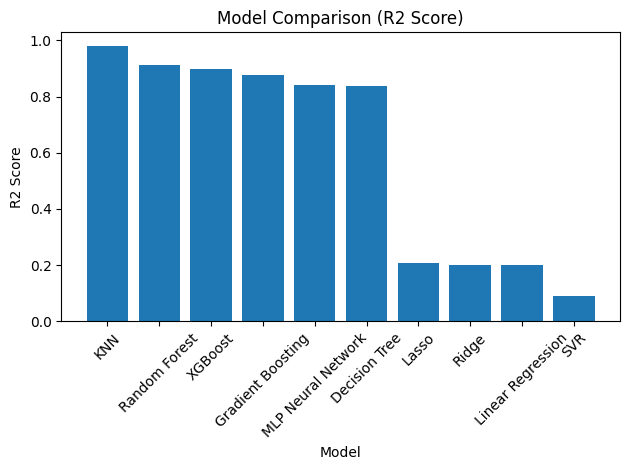

Graph saved as model_comparison_plot.png


In [9]:
# ==============================
# STEP 5: ML MODEL COMPARISON
# ==============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Optional: XGBoost
try:
    from xgboost import XGBRegressor
    xgb_available = True
except:
    xgb_available = False

# ==============================
# Prepare Data
# ==============================

X = df.drop("avg_wait", axis=1)
y = df["avg_wait"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==============================
# Define Models
# ==============================

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "MLP Neural Network": MLPRegressor(max_iter=1000)
}

if xgb_available:
    models["XGBoost"] = XGBRegressor()

# ==============================
# Train + Evaluate
# ==============================

results = []

for name, model in models.items():

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    results.append([name, mse, rmse, r2])

# ==============================
# Create Comparison Table
# ==============================

results_df = pd.DataFrame(results, columns=["Model", "MSE", "RMSE", "R2 Score"])

# Sort by best R2
results_df = results_df.sort_values(by="R2 Score", ascending=False)

print("\n===== MODEL COMPARISON =====\n")
print(results_df)
results_df.to_csv("model_comparison_results.csv", index=False)

print("Model comparison table saved as model_comparison_results.csv")


# ==============================
# Plot Model Performance
# ==============================


plt.figure()
plt.bar(results_df["Model"], results_df["R2 Score"])
plt.xticks(rotation=45)
plt.title("Model Comparison (R2 Score)")
plt.xlabel("Model")
plt.ylabel("R2 Score")

plt.tight_layout()

plt.savefig("model_comparison_plot.png", dpi=300)
plt.show()

print("Graph saved as model_comparison_plot.png")

